In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PhysPropWater import rho
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle

torch.manual_seed(42)
np.random.seed(42)

with open('reacdata.pc','rb') as f:
    data = pickle.load(f)

# Preprocess data
scaler = MinMaxScaler()
X = np.column_stack((data['pH'], data['ratio S/A'])).astype(np.float32)
y = np.array(data['yield']).reshape(-1, 1).astype(np.float32)

y_bin = np.zeros_like(y)
y_bin[y > 0.45] = 1

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

print(X_scaled.shape)
print(y_scaled.shape)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)  # 60% training, 40% temp
#X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% training, 40% temp
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # split temp into 20% val, 20% test

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_valid = torch.tensor(X_val, dtype=torch.float32)
y_valid = torch.tensor(y_val, dtype=torch.float32)
#X_test = torch.tensor(X_test, dtype=torch.float32)
#y_test = torch.tensor(y_test, dtype=torch.float32)

(200, 2)
(200, 1)


In [12]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 20),
            nn.ReLU(),
            nn.Linear(20, 50),
            nn.ReLU(),
            nn.Linear(50, 20),
            nn.ReLU(),
            nn.Linear(20, 1),
            #nn.Sigmoid()    
        )
        
    def forward(self, x):
        return self.model(x)
    
model = Model()
#loss_fn = nn.BCELoss()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [13]:
# Train the model
EPOCHS = 5000
train_losses = []
valid_losses = []

print("Starting training...")

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()
    y_pred_train = model(X_train)
    train_loss = loss_fn(y_pred_train, y_train)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        y_pred_valid = model(X_valid)
        valid_loss = loss_fn(y_pred_valid, y_valid)
        valid_losses.append(valid_loss.item())
    
    # Print the loss every 500 epochs to monitor training
    if epoch % 500 == 0:
        print(f"Epoch {epoch}/{EPOCHS} - Train Loss: {train_loss.item()}, Valid Loss: {valid_loss.item()}")
    
    ## Check convergence
    #if epoch > 300:
    #    diff = train_losses[-300] - train_losses[-1]
    #    if diff > 0 and diff <= 5e-5:
    #        print(f"Model converged after {epoch} epochs\nTrain Loss: {train_loss.item()}\nDerivative: {train_losses[-300] - train_losses[-1] / len(train_losses[-300:-1])}")
    #        break

print("Training completed.")

#pip install -r requirements.txt

Starting training...
Epoch 0/5000 - Train Loss: 0.3768106997013092, Valid Loss: 0.3169708549976349
Epoch 500/5000 - Train Loss: 0.0006722101243212819, Valid Loss: 0.0007586012361571193
Epoch 1000/5000 - Train Loss: 0.00021684644161723554, Valid Loss: 0.00020865772967226803
Epoch 1500/5000 - Train Loss: 0.0001288885105168447, Valid Loss: 0.00019523416995070875
Epoch 2000/5000 - Train Loss: 9.109604434343055e-05, Valid Loss: 0.0001855986483860761
Epoch 2500/5000 - Train Loss: 4.906363392365165e-05, Valid Loss: 0.0001763663749443367
Epoch 3000/5000 - Train Loss: 3.7225163396215066e-05, Valid Loss: 0.00017071518232114613
Epoch 3500/5000 - Train Loss: 2.727651735767722e-05, Valid Loss: 0.00012834159133490175
Epoch 4000/5000 - Train Loss: 2.271804078191053e-05, Valid Loss: 0.00010246729652862996
Epoch 4500/5000 - Train Loss: 2.4876371753634885e-05, Valid Loss: 9.550215327180922e-05
Training completed.


Ncorrect: 154
Nsamples: 200
Accuracy: 0.77


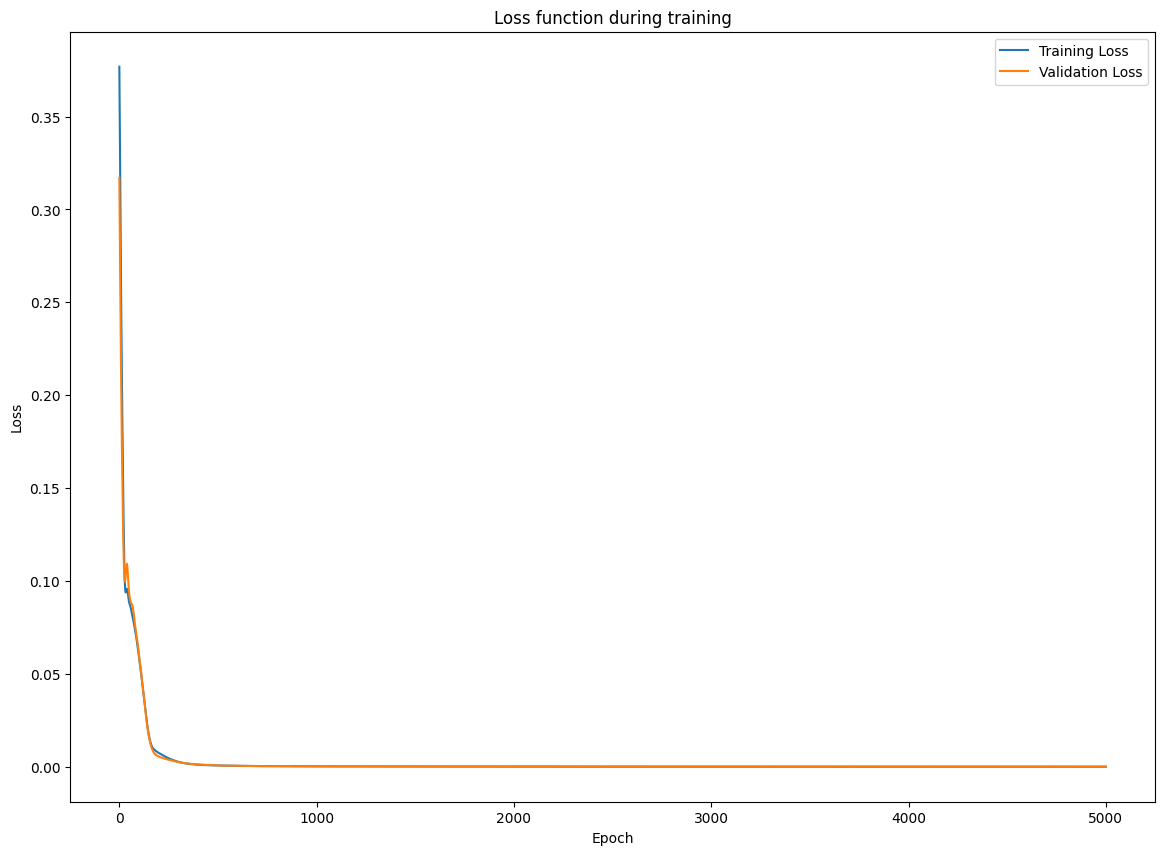

In [16]:
model.eval()
with torch.no_grad():
    y_pred = model(torch.tensor(X_scaled, dtype=torch.float32))

y_bin_pred = torch.zeros_like(y_pred)
y_bin_pred[y_pred > 0.5] = 1

y_bin_tensor = torch.tensor(y_bin, dtype=torch.float32)  # Ensure it's a float tensor
Ncorrect = torch.sum(y_bin_pred == y_bin_tensor).item()
Nsamples = y_bin_tensor.shape[0]
acc = Ncorrect/Nsamples

print(f"Ncorrect: {Ncorrect}")
print(f"Nsamples: {Nsamples}")
print(f"Accuracy: {acc}")

# Plot the loss function
fig, ax = plt.subplots(figsize=(14, 10))

ax.plot(train_losses, label='Training Loss')
ax.plot(valid_losses, label='Validation Loss')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss function during training")
ax.legend()

plt.show()

In [ ]:
"""

plt.figure(figsize=(10, 7))

for i in range(len(X1)):
    if y_bin[i]: # 1
        plt.plot(X1[i], X2[i], 'go')
    else: # 0
        plt.plot(X1[i], X2[i], 'ro')

# Create finely gridded x1 and x2
Ngrid = 100
x1_fine = np.linspace(X1.min().item(), X1.max().item(), Ngrid)
x2_fine = np.linspace(X2.min().item(), X2.max().item(), Ngrid)
X1_fine, X2_fine = np.meshgrid(x1_fine, x2_fine)
# Combine them to a matrix instead for speed
X_fine = np.vstack((X1_fine.flatten(),X2_fine.flatten())).T

X_fine_scaled = scaler.transform(X_fine)  # Use transform, not fit_transform
X_fine_scaled_tensor = torch.tensor(X_fine_scaled, dtype=torch.float32)
y_fine = model(X_fine_scaled_tensor)
# Make it binary
y_fine_binary = (y_fine.detach().numpy() > 0.5).astype(int)
# Reshape it as a matrix
Y_binary = y_fine_binary.reshape((Ngrid, Ngrid))

plt.contourf(X1_fine, X2_fine, Y_binary, levels=[0, 0.5, 1], alpha=0.3) # Use contourf with alpha for better visualization
plt.xlabel('pH')
plt.ylabel('ratio S/A')
plt.title(f'Accuracy: {acc:.5f}')
plt.show()
"""